# Live Object Detection with OpenVINO™

This notebook demonstrates live object detection with OpenVINO, using the [Ultralytics YOLOv8](https://docs.ultralytics.com/models/yolov8/). Final part of this notebook shows live inference results from a webcam. Additionally, you can also upload a video file.

> **NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a server, the webcam will not work. However, you can still do inference on a video.


#### Table of contents:

- [Preparation](#Preparation)
    - [Install requirements](#Install-requirements)
    - [Imports](#Imports)
- [The Model](#The-Model)
    - [Download and convert the Model](#Download-and-convert-the-Model)
    - [Load the Model](#Load-the-Model)
- [Processing](#Processing)
    - [Main Processing Function](#Main-Processing-Function)
- [Run](#Run)
    - [Run Live Object Detection](#Run-Live-Object-Detection)
- [References](#References)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/object-detection-webcam/object-detection.ipynb" />


## Preparation
[back to top ⬆️](#Table-of-contents:)

### Install requirements
[back to top ⬆️](#Table-of-contents:)


In [ ]:
%pip install -q "openvino>=2024.4.0"
%pip install -q "ultralytics==8.3.0" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q opencv-python requests tqdm

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

### Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
from pathlib import Path
import gc
import openvino as ov
from ultralytics import YOLO

import notebook_utils as utils

## The Model
[back to top ⬆️](#Table-of-contents:)

### Download and convert the Model
[back to top ⬆️](#Table-of-contents:)

In [3]:
# A directory where the model will be downloaded.

# The name of the model
model_name = "yolov8n"

det_model_path = Path(f"{model_name}_openvino_model/{model_name}.xml")

# export model to OpenVINO format using Ultralytics API
if not det_model_path.exists():
    pt_model = YOLO(f"{model_name}.pt")
    pt_model.export(format="openvino", dynamic=True, half=True)
    del pt_model
    gc.collect()

### Load the Model
[back to top ⬆️](#Table-of-contents:)

Only a few lines of code are required to run the model. First, initialize OpenVINO Runtime. Then, read the network architecture and model weights from the `.bin` and `.xml` files to compile for the desired device. If you choose `GPU` you need to wait for a while, as the startup time is much longer than in the case of `CPU`.

There is a possibility to let OpenVINO decide which hardware offers the best performance. For that purpose, just use `AUTO`.

In [4]:
core = ov.Core()

device = utils.device_widget()
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [5]:
core = ov.Core()

def load_model(det_model_path, device):
    compiled_model = compile_model(det_model_path, device)
    det_model = YOLO(det_model_path.parent, task="detect")

    if det_model.predictor is None:
        custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}  # method defaults
        args = {**det_model.overrides, **custom}
        det_model.predictor = det_model._smart_load("predictor")(overrides=args, _callbacks=det_model.callbacks)
        det_model.predictor.setup_model(model=det_model.model)

    det_model.predictor.model.ov_compiled_model = compiled_model
    return det_model


def compile_model(det_model_path, device):
    det_ov_model = core.read_model(det_model_path)

    ov_config = {}
    if device != "CPU":
        det_ov_model.reshape({0: [1, 3, 640, 640]})
    if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
    det_compiled_model = core.compile_model(det_ov_model, device, ov_config)
    return det_compiled_model


det_model = load_model(det_model_path, device.value)


Ultralytics 8.3.0 🚀 Python-3.11.4 torch-2.5.1+cpu CPU (Intel Core(TM) i9-10980XE 3.00GHz)
Loading yolov8n_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...


### Main Processing Function
[back to top ⬆️](#Table-of-contents:)

Run object detection on the specified source. Either a webcam or a video file.

In [6]:
import collections
import time
from IPython import display
import cv2
import numpy as np


# Main processing function to run object detection.
def run_object_detection(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    model=det_model,
    device=device.value,
):
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
            detections = det_model(input_image, verbose=False)
            frame = detections[0].plot()

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

## Run
[back to top ⬆️](#Table-of-contents:)

### Run Live Object Detection
[back to top ⬆️](#Table-of-contents:)

Use a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

> **NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a server (for example, Binder), the webcam will not work. Popup mode may not work if you run this notebook on a remote computer (for example, Binder).

If you do not have a webcam, you can still run this demo with a video file. Any [format supported by OpenCV](https://docs.opencv.org/4.5.1/dd/d43/tutorial_py_video_display.html) will work.

Run the object detection:

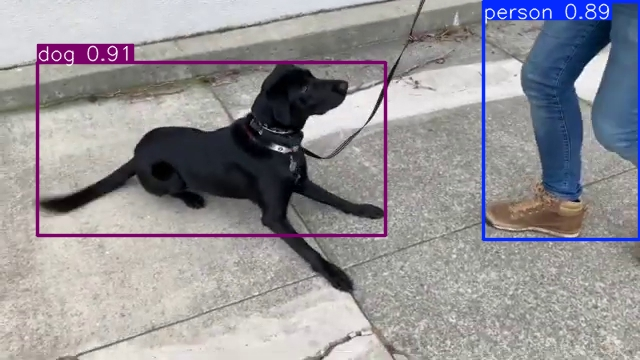

Source ended


In [7]:
USE_WEBCAM = False

video_file = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4"
cam_id = 0

source = cam_id if USE_WEBCAM else video_file

run_object_detection(source=source, flip=isinstance(source, int), use_popup=False)